# Data Inspection

## Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import pycountry

## Load Data

In [2]:
country_df = pd.read_pickle("../../data/generated/country_df.pkl")
comes_from_df = pd.read_pickle("../../data/generated/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/generated/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/generated/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/generated/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/generated/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/generated/character_df.pkl")
actor_df = pd.read_pickle("../../data/generated/actor_df.pkl")
movie_df = pd.read_pickle("../../data/generated/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/generated/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/generated/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/generated/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")

## Helpers

In [3]:
COUNTRY_MAPPING = {"west germany": "germany", "weimar republic": "germany",
"german democratic republic": "germany",
"nazi germany": "germany", "german language": "germany",
"soviet union": "russia", "soviet occupation zone": "russia",
"socialist federal republic of yugoslavia": "yugoslavia", 
"federal republic of yugoslavia" : "yugoslavia",
"uzbek ssr" : "uzbekistan",
"georgian ssr": "georgia",
"kingdom of great britain": "united kingdom", "northern ireland": "united kingdom",
"wales": "united kingdom", "england": "united kingdom", "scotland": "united kingdom",
"serbia and montenegro" : "serbia and montenegro",
"kingdom of italy": "italy",
"mandatory palestine": "palestinian territories",
"ukranian ssr": "ukraine", "ukrainian ssr": "ukraine",
"malayalam language": "india",
"slovak republic" : "slovakia", "republic of china": "china"}

In [4]:
CUSTOM_ALPHA3_CODE_MAPPING = {"bolivia":"BOL","burma":"BUR",
"czech republic":"CZE","czechoslovakia":"CSK",
"democratic republic of the congo":"COD","england":"GBR",
"federal republic of yugoslavia":"YUG","georgian ssr": "GEO",
"german democratic republic":"DEU","german":"DEU",
"iran":"IRN","kingdom of great britain":"GBR",
"kingdom of italy":"ITA","korea":"KOR",
"macau":"MAC","mandatory palestine":"PSE",
"nazi germany":"DEU","northern ireland":"GBR",
"palestinian territories":"PSE","republic of china":"CHN",
"republic of macedonia":"MKD","russia":"RUS",
"scotland":"GBR","serbia and montenegro":"SCG",
"slovak republic":"SVK","socialist federal republic of yugoslavia":"YUG",
"south korea":"KOR","soviet occupation zone":"RUS",
"soviet union":"RUS","taiwan":"TWN",
"ukrainian ssr":"UKR","ukranian ssr":"UKR",
"united states of america":"USA","uzbek ssr":"UZB",
"venezuela":"VEN","vietnam":"VNM",
"wales":"GBR","weimar republic":"DEU",
"west germany":"DEU","yugoslavia":"YUG",
"german language":"DEU"}

In [5]:
def alpha3code(country:str)->str:
    """
    Get the ISO_3166-1 alpha-3 code for the given country.
    
    :param country: Country name.
    
    :return: Three letters alpha-3 code, or "None" if not available.
    """
    CODE = "None"
    try:
        CODE = pycountry.countries.get(name=country).alpha_3
    except:
        if country in CUSTOM_ALPHA3_CODE_MAPPING.keys():
            CODE = CUSTOM_ALPHA3_CODE_MAPPING[country]
    return CODE

In [6]:
def movie_count_bar_plot(movie_count_df: pd.DataFrame,title: str,is_log=False):
    """
    Plot the movie count per entry in the given dataframe.
    
    :param movie_count_df: Pandas dataframe with one column for the movie count
                           and the entry name as index.
    :param title: Title of the plot.
    :param is_log: Boolean indicating if the count is in log scale.
    
    """
    plot_height = np.ceil(len(movie_count_df)/5)
    fig, ax = plt.subplots(1,figsize=(10,plot_height))
    ax.set_title(title)
    sns.barplot(x=movie_count_df.movie_count,y=movie_count_df.index,
                orient="h",ax=ax, color="grey")
    if is_log:
        ax.set_xlabel("Movie number in log scale");
    else:
        ax.set_xlabel("Movie number");

In [82]:
def count_box_plot(count_df: pd.DataFrame, title: str):
    """
    Plot the movie count distribution in a box plot.
    
    :param count_df: Pandas dataframe with one column for the entry count
                           and the entry name as index.
    :param title: Title of the plot.
    :param is_log: Boolean indicating if the count is in log scale.
    
    """
    fig,axs = plt.subplots(1,2,figsize=(6,6))
    fig.suptitle(title)
    sns.boxplot(count_df,ax=axs[0])
    axs[0].set_title("With outliers")
    sns.boxplot(count_df,showfliers=False,ax=axs[1])
    axs[1].set_title("Without outliers");

In [117]:
def count_draw_histogram(count_df: pd.DataFrame, log_count_df: pd.DataFrame,
                         title: str, is_log=False):
    """
    Plot the histogram of the movie counts in normal and log scale.
    
    :param count_df: Pandas dataframe with one column for the entry count
                           and the entry name as index.
    :param count_df: Pandas dataframe with one column for the entry count
                           in log scale and the entry name as index.
    :param title: Title of the plot.
    
    """
    fig,axs = plt.subplots(1,2,figsize=(12,6))
    fig.suptitle(title)
    sns.histplot(count_df,ax=axs[0])
    count_quantity = count_df.index.name.split("_")[0]
    axs[0].set_title("Standard Scale")
    axs[0].set_xlabel(f"{count_df.columns[0]}")
    axs[0].set_ylabel(f"Count of {count_quantity}")
    sns.histplot(log_count_df,ax=axs[1])
    axs[1].set_xlabel(f"Log({count_df.columns[0]})")
    axs[1].set_ylabel(f"Count of {count_quantity}")
    axs[1].set_title("Log Scale");
    if is_log:
        for ax in axs:
            ax.set_yscale("log")
            ax.set_ylabel("Log(Count)")

## Country

Movie Distribution Among Countries

#### Country Aggregation

Some countries are duplicated because for example of different time scales (e.g. nazi germany, west germany, recent germany). Then we have to aggregate them together.

In [84]:
serbia_and_montenegro_ids = comes_from_df[
    comes_from_df["country_name"] == "serbia and montenegro"]["movie_id"].to_list()
comes_from_df = comes_from_df[comes_from_df["country_name"] != "serbia and montenegro"]
new_serbia_entries = pd.DataFrame(
    zip(serbia_and_montenegro_ids,["serbia"]*len(serbia_and_montenegro_ids)),
    columns=["movie_id","country_name"])
new_montenegro_entries = pd.DataFrame(
    zip(serbia_and_montenegro_ids,["montenegro"]*len(serbia_and_montenegro_ids)),
    columns=["movie_id","country_name"])
comes_from_df = pd.concat([comes_from_df,new_serbia_entries,new_montenegro_entries]).drop_duplicates()

In [85]:
comes_from_df["country_name"] = comes_from_df["country_name"].apply(lambda c: COUNTRY_MAPPING[c] if c in COUNTRY_MAPPING.keys() else c)

### Descriptive statistics
Our data has a heavy tail, with a lot of countries having only a few movies. We will thus need to use robust statistics.

In [86]:
country_count_df = comes_from_df.groupby("country_name").count().sort_values("movie_id",key=lambda l: -l)
country_count_df.columns = ["movie_count"]
country_log_count_df = country_count_df.apply(np.log)

In [87]:
country_count_median = country_count_df.median().item()
print(f"The median number of movies per country is {country_count_median}.")

The median number of movies per country is 42.0.


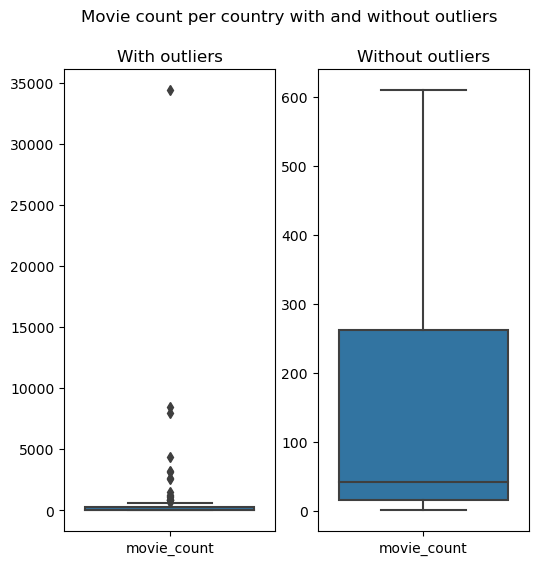

In [88]:
count_box_plot(country_count_df,"Movie count per country with and without outliers")

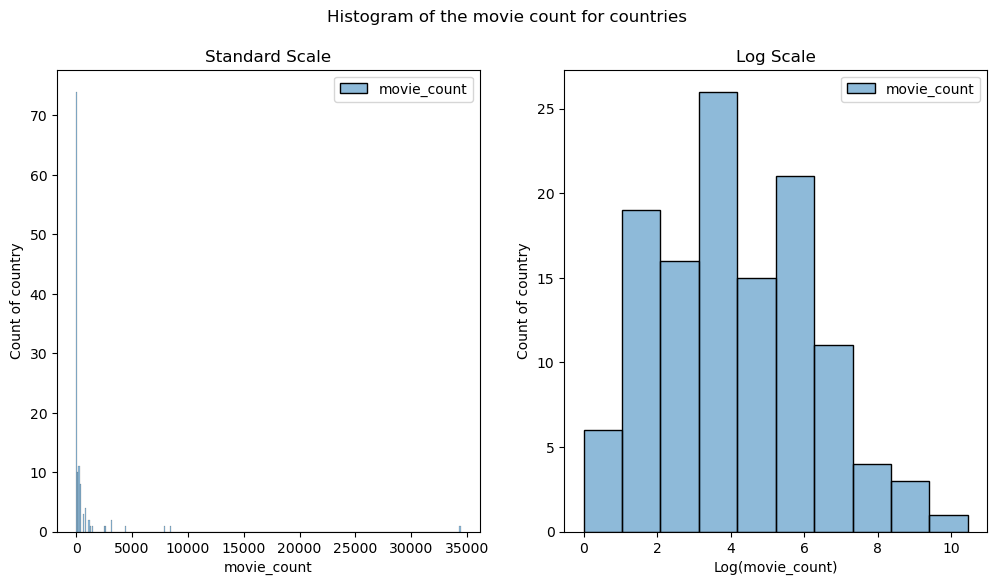

In [89]:
count_draw_histogram(country_count_df,country_log_count_df,
                           "Histogram of the movie count for countries")

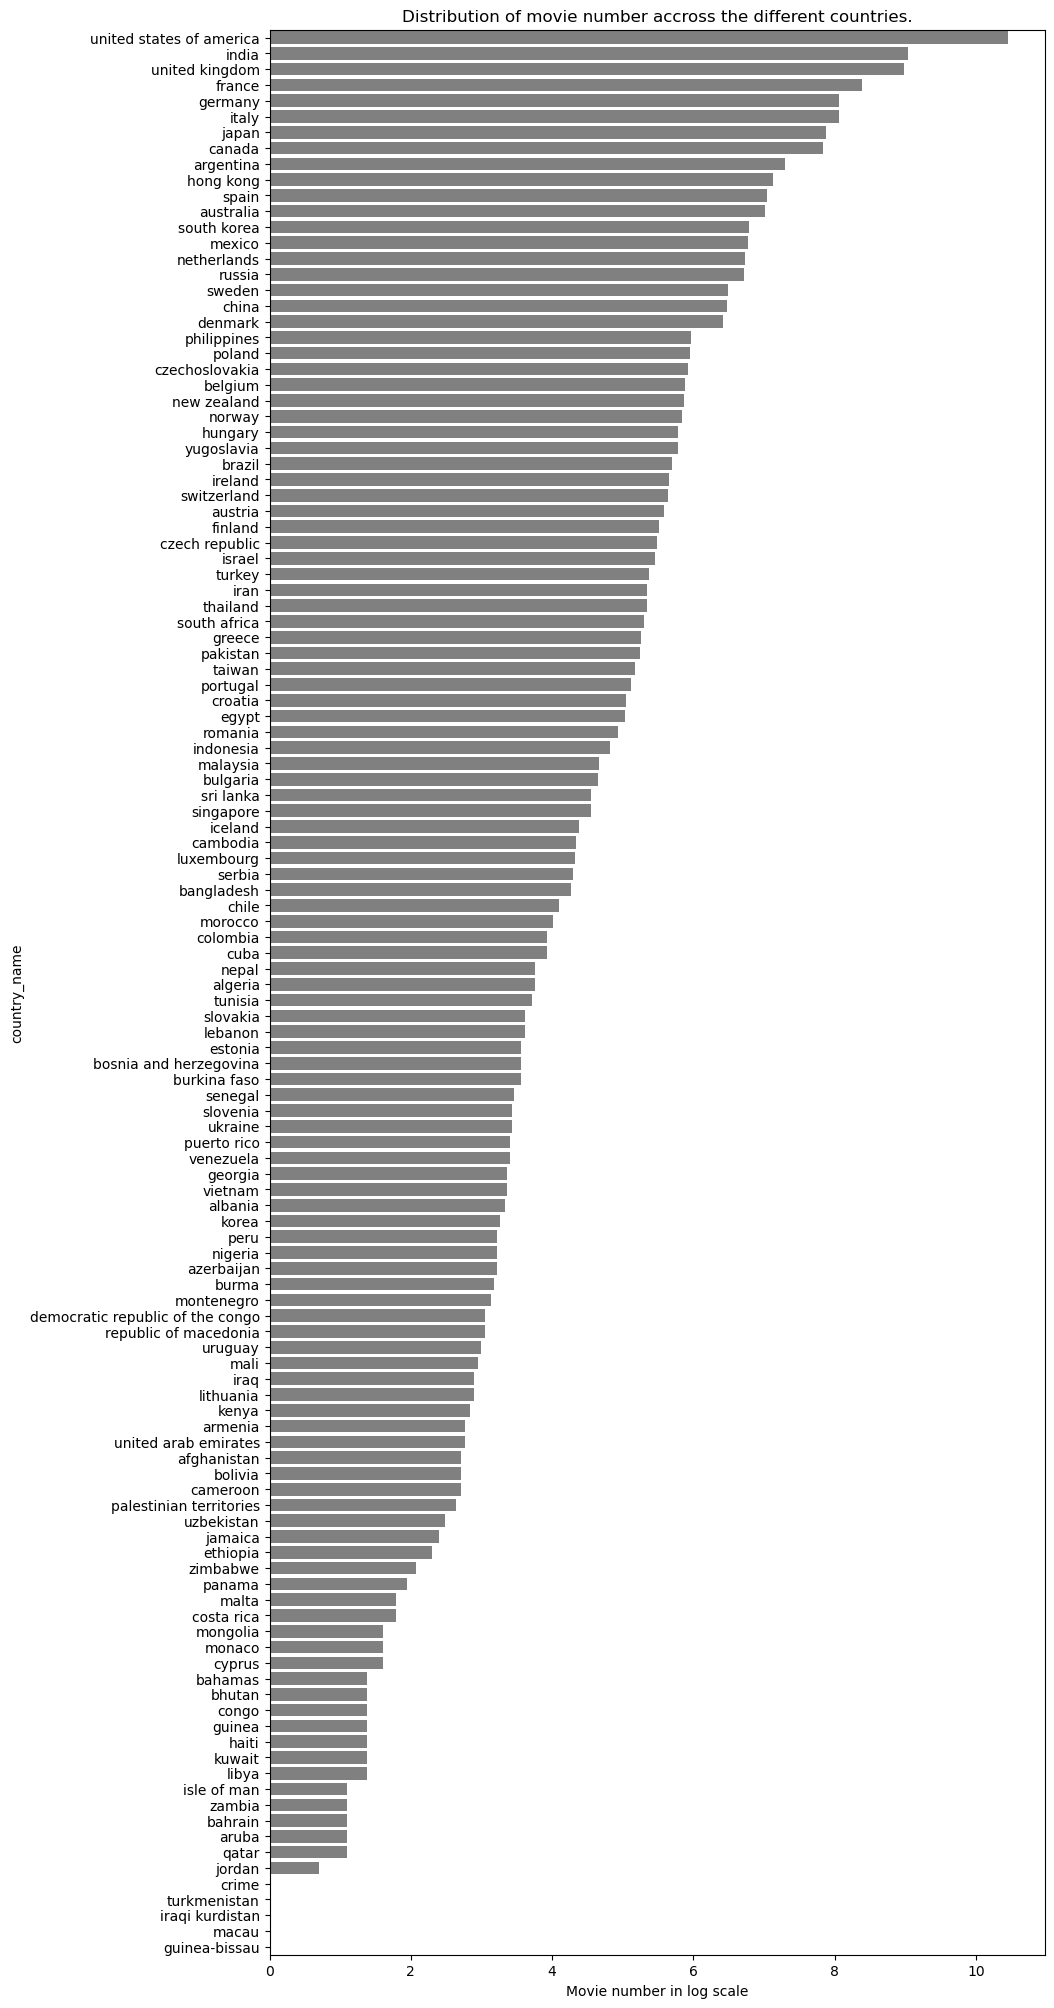

In [90]:
movie_count_bar_plot(country_log_count_df,"Distribution of movie number accross the different countries.",
                    is_log=True)

### Top and bottom countries

In [91]:
print("The top 10 countries are:\n")
print(country_count_df.head(10).to_markdown())
print("\nThe bottom 10 countries are:\n")
print(country_count_df.tail(10).to_markdown())

The top 10 countries are:

| country_name             |   movie_count |
|:-------------------------|--------------:|
| united states of america |         34408 |
| india                    |          8412 |
| united kingdom           |          7941 |
| france                   |          4395 |
| germany                  |          3170 |
| italy                    |          3164 |
| japan                    |          2647 |
| canada                   |          2534 |
| argentina                |          1468 |
| hong kong                |          1240 |

The bottom 10 countries are:

| country_name    |   movie_count |
|:----------------|--------------:|
| zambia          |             3 |
| bahrain         |             3 |
| aruba           |             3 |
| qatar           |             3 |
| jordan          |             2 |
| crime           |             1 |
| turkmenistan    |             1 |
| iraqi kurdistan |             1 |
| macau           |             1 |
| guin

### World Map 

In [92]:
country_code_log_count_df = country_log_count_df.reset_index()
country_code_log_count_df["CODE"] = country_code_log_count_df["country_name"].apply(alpha3code)
country_code_log_count_df = country_code_log_count_df.set_index("country_name")

In [93]:
world_countries_df = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
world_countries_df.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world_wrong_code_ids = world_countries_df["CODE"] == "-99"
world_wrong_code = world_countries_df[world_wrong_code_ids]
world_countries_df.loc[world_wrong_code_ids,"CODE"] = world_wrong_code["name"].apply(alpha3code)
world_merge = world_countries_df.merge(country_code_log_count_df,on='CODE')
world_merge = world_merge[~(world_merge["CODE"] == "None")]

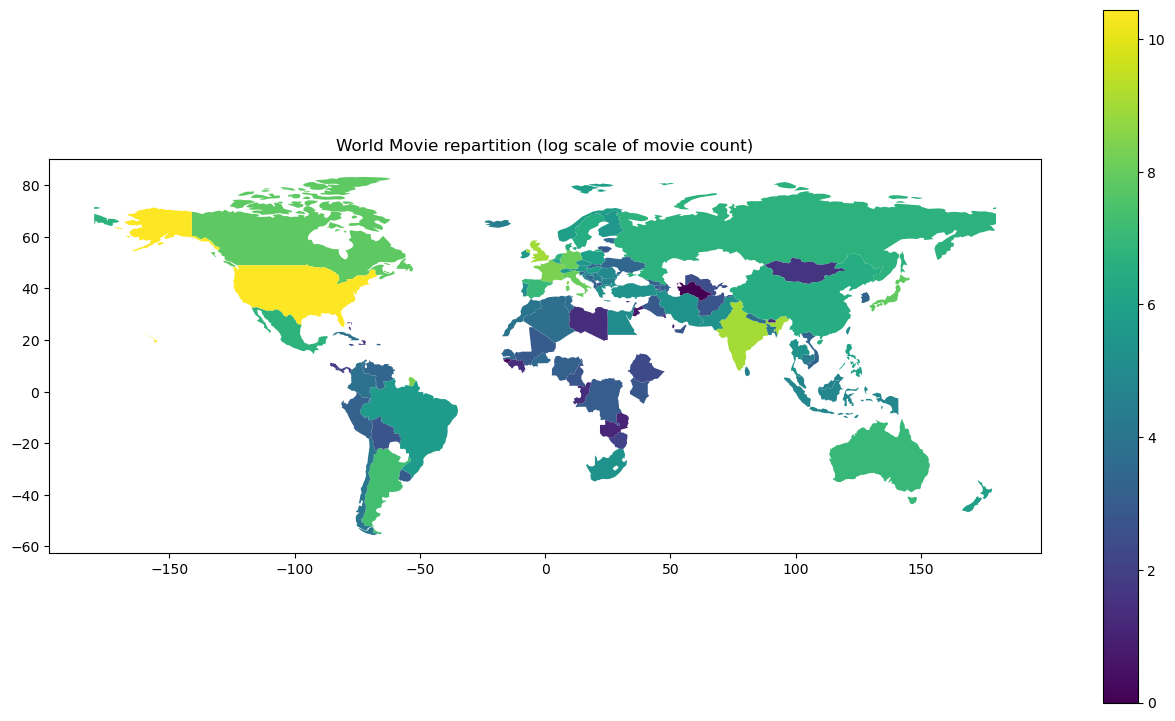

In [94]:
fig,ax = plt.subplots(1,figsize=(16,9))
ax.set_title("World Movie repartition (log scale of movie count)")
world_merge.plot(column="movie_count",legend=True,ax=ax);

## Movie Country Relation

In [95]:
country_per_movie_count_df = comes_from_df.groupby("movie_id").count().sort_values("country_name",key=lambda l: -l)
country_per_movie_count_df.columns = ["country_count"]
country_per_movie_log_count_df = country_per_movie_count_df.apply(np.log)

In [96]:
country_per_movie_count_median = country_per_movie_count_df.median().item()
print(f"The median number of countries per movie is {country_per_movie_count_median}.")

The median number of countries per movie is 1.0.


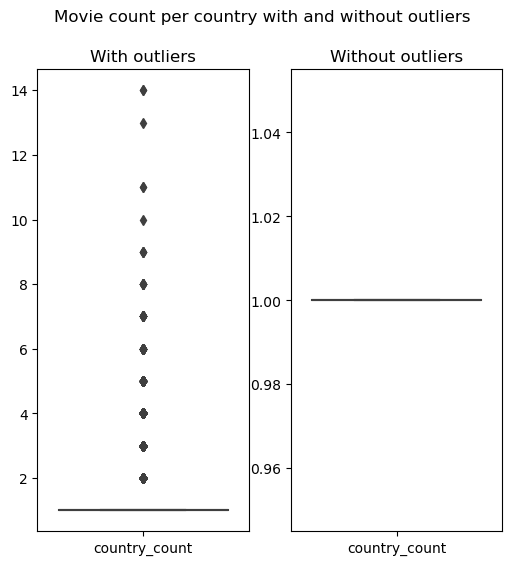

In [97]:
count_box_plot(country_per_movie_count_df,"Movie count per country with and without outliers")

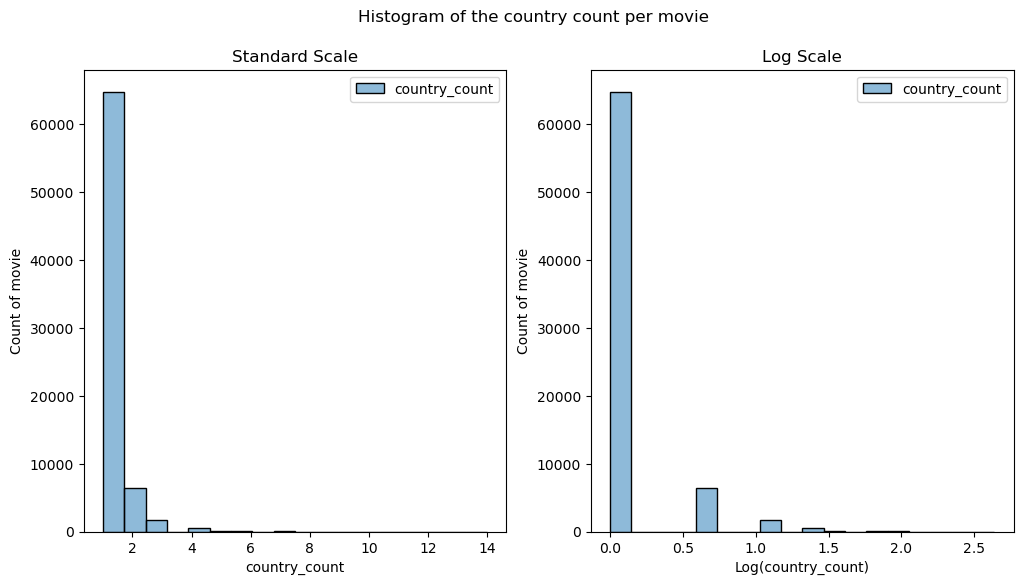

In [98]:
count_draw_histogram(country_per_movie_count_df,country_per_movie_log_count_df,
                           "Histogram of the country count per movie")

### Top and bottom movies

In [99]:
top_name_movies = country_per_movie_count_df.head(10).reset_index()
top_name_movies["movie_name"] = top_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
top_name_movies = top_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("The top 10 movies are:\n")
print(top_name_movies.to_markdown())
bot_name_movies = country_per_movie_count_df.tail(10).reset_index()
bot_name_movies["movie_name"] = bot_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
bot_name_movies = bot_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("\nThe bottom 10 movies are:\n")
print(bot_name_movies.to_markdown())

The top 10 movies are:

| movie_name                                |   country_count |
|:------------------------------------------|----------------:|
| The Mahabharata                           |              14 |
| My Reincarnation                          |              14 |
| Dancer in the Dark                        |              13 |
| Burma VJ: Reporting from a Closed Country |              11 |
| Manderlay                                 |              11 |
| Dragon Hunters                            |              10 |
| Bananas!*                                 |               9 |
| The Best Intentions                       |               9 |
| Thieves By Law                            |               9 |
| Ulysses' Gaze                             |               9 |

The bottom 10 movies are:

| movie_name         |   country_count |
|:-------------------|----------------:|
| The Egg and I      |               1 |
| The Secret Heart   |               1 |
| Sleep, My Love

## Genres


### Descriptive statistics
Our data has a heavy tail, with a lot of genres appearing only in a few movies. We will thus need to use robust statistics.

In [100]:
genre_count_df = is_of_type_df.groupby("genre_name").count().sort_values(
    "movie_id",key=lambda l: -l)
genre_count_df.columns = ["movie_count"]
genre_log_count_df = genre_count_df.apply(np.log)

In [101]:
genre_median_count = genre_count_df.median().item()
print(f"The median number of movies per genre is {genre_median_count}.")

The median number of movies per genre is 65.0.


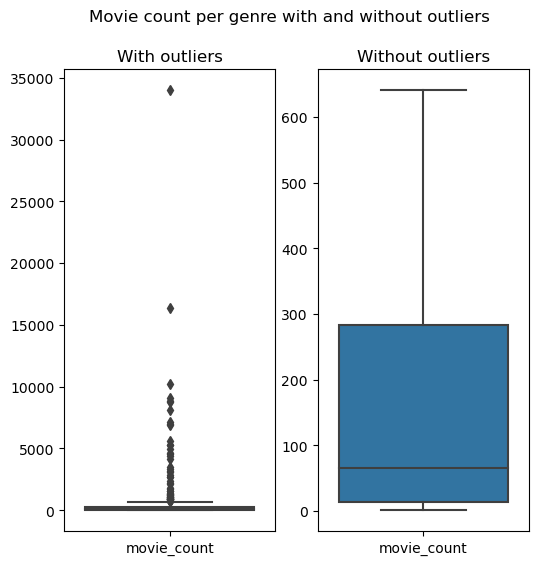

In [102]:
count_box_plot(genre_count_df,"Movie count per genre with and without outliers")

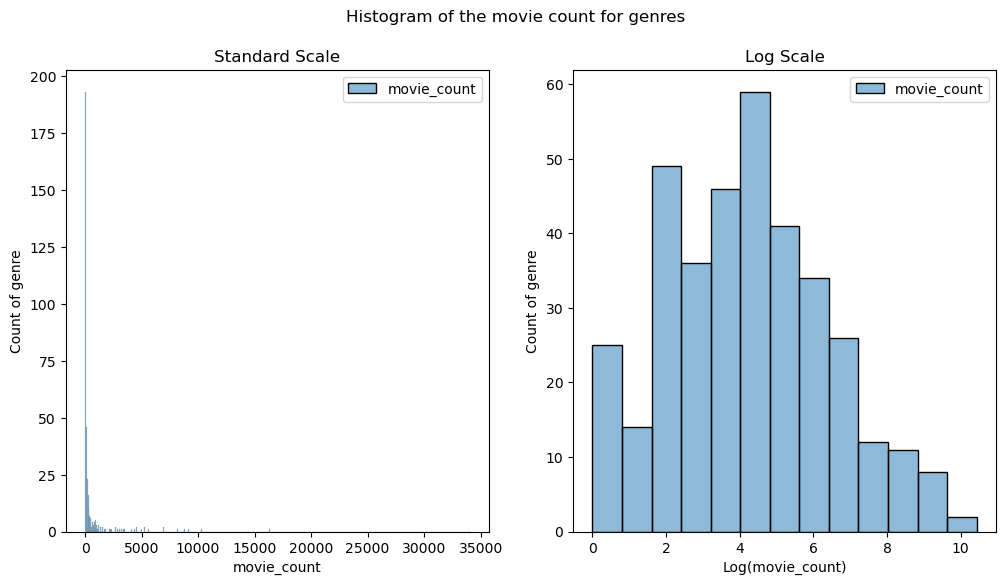

In [103]:
count_draw_histogram(genre_count_df,genre_log_count_df,
                           "Histogram of the movie count for genres")

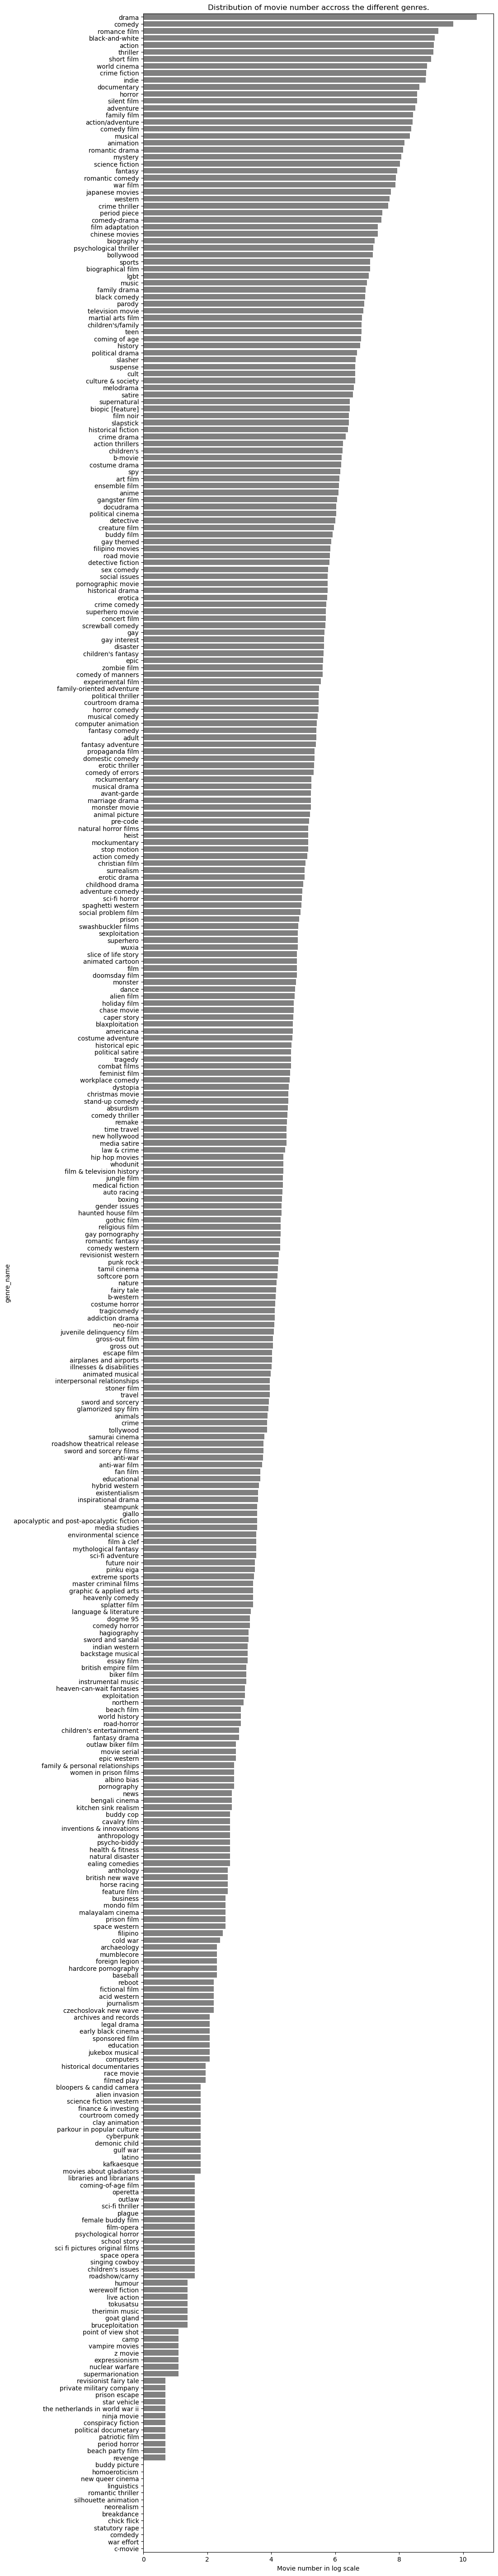

In [104]:
movie_count_bar_plot(genre_log_count_df,"Distribution of movie number accross the different genres.",
                    is_log=True)

### Top and bottom genres

In [105]:
print("The top 10 genres are:\n")
print(genre_count_df.head(10).to_markdown())
print("\nThe bottom 10 genres are:\n")
print(genre_count_df.tail(10).to_markdown())

The top 10 genres are:

| genre_name      |   movie_count |
|:----------------|--------------:|
| drama           |         34007 |
| comedy          |         16349 |
| romance film    |         10234 |
| black-and-white |          9094 |
| action          |          8798 |
| thriller        |          8744 |
| short film      |          8141 |
| world cinema    |          7155 |
| crime fiction   |          6948 |
| indie           |          6897 |

The bottom 10 genres are:

| genre_name           |   movie_count |
|:---------------------|--------------:|
| linguistics          |             1 |
| romantic thriller    |             1 |
| silhouette animation |             1 |
| neorealism           |             1 |
| breakdance           |             1 |
| chick flick          |             1 |
| statutory rape       |             1 |
| comdedy              |             1 |
| war effort           |             1 |
| c-movie              |             1 |


## Movie Country Relation

In [111]:
genre_per_movie_count_df = is_of_type_df.groupby("movie_id").count().sort_values("genre_name",key=lambda l: -l)
genre_per_movie_count_df.columns = ["genre_count"]
genre_per_movie_log_count_df = genre_per_movie_count_df.apply(np.log)

In [112]:
genre_per_movie_count_median = genre_per_movie_count_df.median().item()
print(f"The median number of countries per movie is {genre_per_movie_count_median}.")

The median number of countries per movie is 3.0.


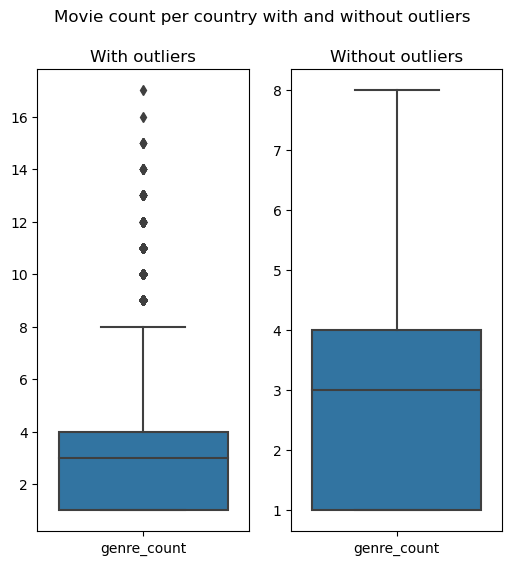

In [113]:
count_box_plot(genre_per_movie_count_df,"Movie count per country with and without outliers")

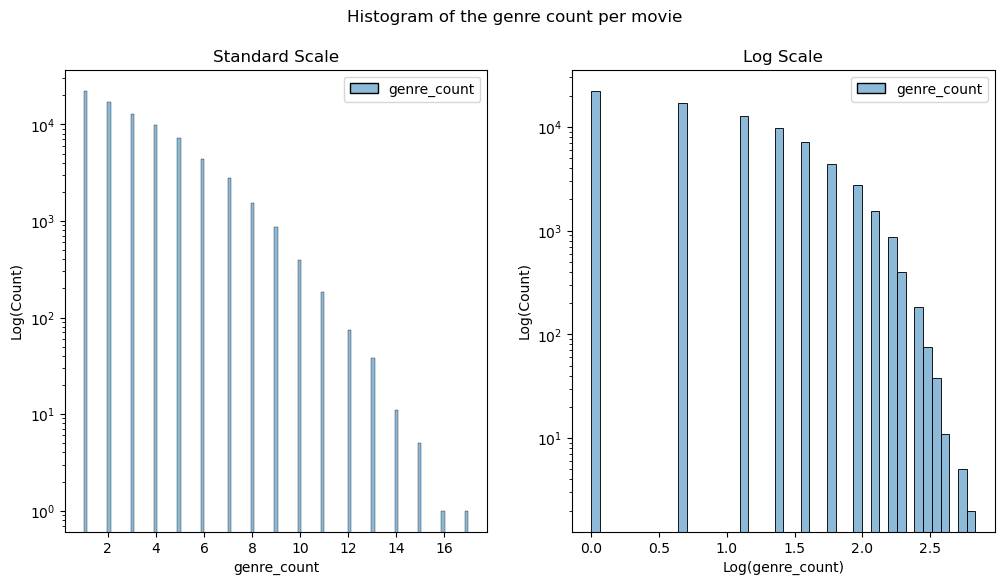

In [119]:
count_draw_histogram(genre_per_movie_count_df,genre_per_movie_log_count_df,
                           "Histogram of the genre count per movie", is_log=True)

### Top and bottom movies

In [115]:
top_name_movies = genre_per_movie_count_df.head(10).reset_index()
top_name_movies["movie_name"] = top_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
top_name_movies = top_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("The top 10 movies are:\n")
print(top_name_movies.to_markdown())
bot_name_movies = genre_per_movie_count_df.tail(10).reset_index()
bot_name_movies["movie_name"] = bot_name_movies["movie_id"].apply(lambda i: movie_df.loc[i,"name"])
bot_name_movies = bot_name_movies.set_index("movie_name").drop("movie_id",axis=1)
print("\nThe bottom 10 movies are:\n")
print(bot_name_movies.to_markdown())

The top 10 movies are:

| movie_name                                       |   genre_count |
|:-------------------------------------------------|--------------:|
| Young Sherlock Holmes                            |            17 |
| Naked Lunch                                      |            16 |
| Van Helsing                                      |            15 |
| Caligula                                         |            15 |
| Donnie Darko                                     |            15 |
| The Adventures of Priscilla, Queen of the Desert |            15 |
| The Raspberry Reich                              |            15 |
| The Doom Generation                              |            14 |
| The Sum of Us                                    |            14 |
| Brotherhood of the Wolf                          |            14 |

The bottom 10 movies are:

| movie_name                     |   genre_count |
|:-------------------------------|--------------:|
| Undercover      

## Languages

### Descriptive statistics
Our data has a heavy tail, with a lot of languages appearing only in a few movies. We will thus need to use robust statistics.

In [ ]:
language_count_df = spoken_languages_df.groupby("language_name").count().sort_values(
    "movie_id",key=lambda l: -l)
language_count_df.columns = ["movie_count"]
language_log_count_df = language_count_df.apply(np.log)

In [ ]:
language_median_count = language_count_df.median().item()
print(f"The median number of movies per language is {language_median_count}.")

In [ ]:
movie_count_box_plot(language_count_df,"Movie count per language with and without outliers")

In [ ]:
movie_count_draw_histogram(language_count_df,language_log_count_df,
                           "Histogram of the movie count for languages")

In [ ]:
movie_count_bar_plot(language_log_count_df,"Distribution of movie number accross the different languages.",
                    is_log=True)

### Top and bottom countries

In [ ]:
print("The top 10 languages are:\n")
print(language_count_df.head(10).to_markdown())
print("\nThe bottom 10 languages are:\n")
print(language_count_df.tail(10).to_markdown())